In [48]:
import os
import calendar
import theano
from theano import *
import theano.tensor as tt
import scipy.stats as stats
from theano.compile.ops import as_op
import matplotlib.pyplot as plt
from argparse import Namespace
import pandas as pd
import numpy as np
import pymc3 as pm
import argparse
import pickle
import json
import math
import sys  

sys.path.insert(0, '/Users/Yannis/code/fibe2-mini-project/models')
from HymodModel import HymodModel as HYMOD

# Import data

In [49]:
# Get current working directory and project root directory
cwd = os.getcwd()
rd = os.path.join(cwd.split('fibe2-mini-project/', 1)[0])
if not rd.endswith('fibe2-mini-project'):
    rd = os.path.join(cwd.split('fibe2-mini-project/', 1)[0],'fibe2-mini-project')

In [50]:
model0data = pd.read_csv(os.path.join(rd,'data','output','simulations','linear_reservoir_simulation_monthly.csv'))
# model1data = pd.read_csv(os.path.join(rd,'data','output','simulations','nonlinear_reservoir_simulation_monthly.csv'))
model2data = pd.read_csv(os.path.join(rd,'data','output','simulations','hymod_simulation_monthly.csv'))
model2data['date'] = pd.to_datetime(model2data['date'])
model2data['time_label'] = model2data['date'].apply(lambda x: f'{calendar.month_abbr[x.month]}-{str(x.year)[-2:]}')

# Store net net_rainfall
nr = model0data['net_rainfall'].values.tolist()
et = model0data['evapotranspiration'].values.tolist()
n = len(nr)

with open(os.path.join(rd,'data','output','simulations/hymod_simulation_monthly_true_parameters.json'), 'r') as f:
    hymod_true_params = json.load(f)
hymod_true_args = Namespace(**hymod_true_params)

with open(os.path.join(rd,'data','output','posterior_samples/hymod_samples_monthly_priors.json'), 'r') as f:
    hymod_prior_params = json.load(f)
hymod_prior_args = Namespace(**hymod_prior_params)

In [51]:
hymod = HYMOD(nr,et,hymod_true_args)

@as_op(itypes=[tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar], otypes=[tt.dmatrix])
def th_forward_model(param1,param2,param3,param4,param5):
    parameter_list = [param1,param2,param3,param4,param5]

    th_states = hymod.simulate(parameter_list,hymod_true_args)
    return th_states

In [52]:
# Path to files
csv_file = os.path.join(rd,'data','output','posterior_samples/linear_reservoir_samples.csv')

HYMODtrace_LRMdata_file = os.path.join(rd,'data','output','posterior_samples/hymod_samples_monthly_LRMdata_trace.pickle')
HYMODmodel_LRMdata_file = os.path.join(rd,'data','output','posterior_samples/hymod_samples_monthly_LRMdata_model.pickle')

HYMODtrace_HYMODdata_file = os.path.join(rd,'data','output','posterior_samples/hymod_samples_monthly_HYMODdata_trace.pickle')
HYMODmodel_HYMODdata_file = os.path.join(rd,'data','output','posterior_samples/hymod_samples_monthly_HYMODdata_model.pickle')

In [53]:
# Read files
# results = pd.read_csv(csv_file)

HYMODtrace_HYMODdata = open(HYMODtrace_HYMODdata_file,"rb")
HYMODmodel_HYMODdata = open(HYMODmodel_HYMODdata_file,"rb")
HYMODtrace_HYMODdata = pickle.load(HYMODtrace_HYMODdata)
HYMODmodel_HYMODdata = pickle.load(HYMODmodel_HYMODdata)

HYMODtrace_LRMdata = open(HYMODtrace_LRMdata_file,"rb")
HYMODmodel_LRMdata = open(HYMODmodel_LRMdata_file,"rb")
HYMODtrace_LRMdata = pickle.load(HYMODtrace_LRMdata)
HYMODmodel_LRMdata = pickle.load(HYMODmodel_LRMdata)

traces = {"HYMOD":HYMODtrace_HYMODdata}#"LRM":HYMODtrace_LRMdata}
models = {"HYMOD":HYMODmodel_HYMODdata}#"LRM":HYMODmodel_LRMdata}

In [54]:
keys = ['current_model','true_model','parameter','marginal_likelihood','mean', 'sd', 'mc_error', 'hpd_2.5', 'hpd_97.5']
results = pd.DataFrame(columns=keys)
for mi in ['HYMOD']:#,'LRM']:
    vals = np.append(np.array(['HYMOD',mi,'cmax',models[mi].marginal_likelihood]),pm.summary(traces[mi], ['cmax']).values[0])
    results = results.append(dict(zip(keys, vals)),ignore_index=True)
    vals = np.append(np.array(['HYMOD',mi,'kfast',models[mi].marginal_likelihood]),pm.summary(traces[mi], ['kfast']).values[0])
    results = results.append(dict(zip(keys, vals)),ignore_index=True)
    vals = np.append(np.array(['HYMOD',mi,'kslow',models[mi].marginal_likelihood]),pm.summary(traces[mi], ['kslow']).values[0])
    results = results.append(dict(zip(keys, vals)),ignore_index=True)
    vals = np.append(np.array(['HYMOD',mi,'betak',models[mi].marginal_likelihood]),pm.summary(traces[mi], ['betak']).values[0])
    results = results.append(dict(zip(keys, vals)),ignore_index=True)
    vals = np.append(np.array(['HYMOD',mi,'alfa',models[mi].marginal_likelihood]),pm.summary(traces[mi], ['alfa']).values[0])
    results = results.append(dict(zip(keys, vals)),ignore_index=True)
    vals = np.append(np.array(['HYMOD',mi,'sigma',models[mi].marginal_likelihood]),pm.summary(traces[mi], ['sigma']).values[0])
    results = results.append(dict(zip(keys, vals)),ignore_index=True)

In [55]:
results

,current_model,true_model,parameter,marginal_likelihood,mean,sd,mc_error,hpd_2.5,hpd_97.5
0,HYMOD,HYMOD,cmax,8.96482654557642e-12,206.41278958828542,111.25156841980942,1.6185316419330547,38.71478590957872,396.78175115760695
1,HYMOD,HYMOD,kfast,8.96482654557642e-12,1.1557272897043604,0.08516669329265779,0.0010982554169388233,1.068583097645689,1.283039348496943
2,HYMOD,HYMOD,kslow,8.96482654557642e-12,1.436727275801425,0.11860028309293337,0.001683849702353054,1.1757900352497308,1.6683622065980244
3,HYMOD,HYMOD,betak,8.96482654557642e-12,0.34810944172795044,0.24767741309574984,0.0034131475598184425,0.011447453893455285,0.826630313985052
4,HYMOD,HYMOD,alfa,8.96482654557642e-12,0.2623276317068212,0.16597127617779456,0.0022586569738799124,0.007322781996855188,0.6089170073207245
5,HYMOD,HYMOD,sigma,8.96482654557642e-12,0.49815607598146944,0.07473652633812389,0.0008988058997557771,0.37069458601362887,0.6547627404456999


# Parameter posteriors

In [56]:
colors = ['b','g','r','c','m','y']

In [57]:
scalefactor = 50

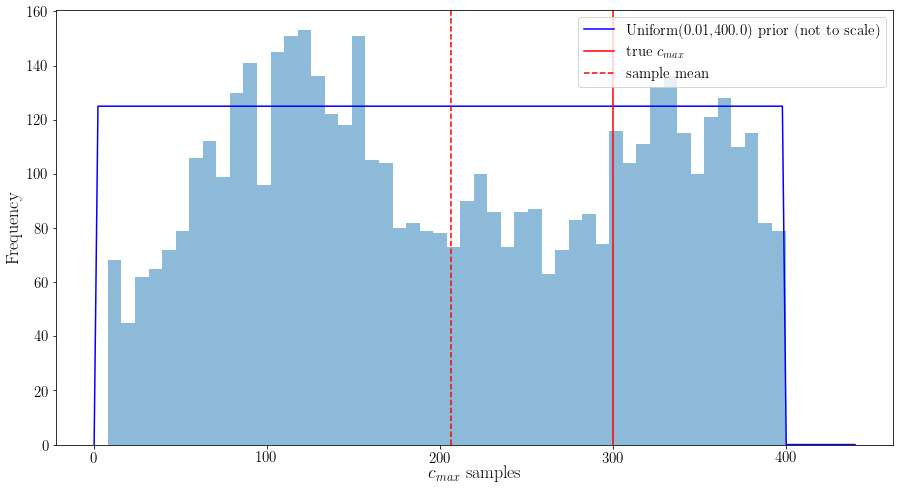

In [25]:
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

x = np.linspace(0, hymod_prior_args.c_max*11/10, 200) 
y1 = stats.uniform.pdf(x, loc=0.01, scale=hymod_prior_args.c_max)

plt.hist(HYMODtrace_HYMODdata['cmax'],bins=50,alpha=0.5)
plt.plot(x, y1*50000, label=(f'Uniform(0.01,{hymod_prior_args.c_max}) prior (not to scale)'),color=colors[0]) 
plt.xlabel(r'$c_{max}$ samples',fontsize=18)
plt.ylabel(r'Frequency',fontsize=18)
plt.axvline(x=hymod_true_args.cmax,color='r',label=r'true $c_{max}$')
plt.axvline(x=np.mean(HYMODtrace_HYMODdata['cmax']),color='r',linestyle='--',label='sample mean')
plt.legend(prop={'size': 15})

plt.savefig(os.path.join(rd,'data','figures','hymod_cmax_hist.png'))
plt.show()

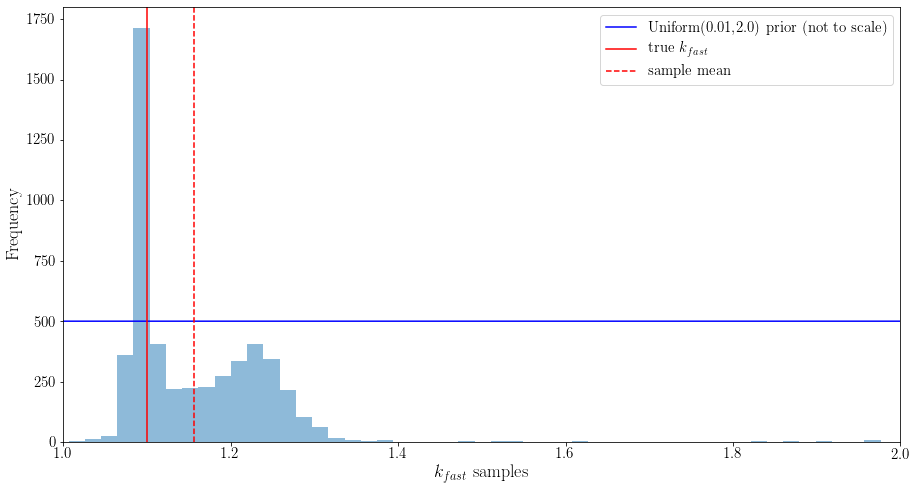

In [58]:
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

x = np.linspace(0, hymod_prior_args.kfast_max*11/10, 200) 
y1 = stats.uniform.pdf(x, loc=0.01, scale=hymod_prior_args.kfast_max)

plt.hist(HYMODtrace_HYMODdata['kfast'],bins=50,alpha=0.5)
plt.plot(x, y1*1000, label=(f'Uniform(0.01,{hymod_prior_args.kfast_max}) prior (not to scale)'),color=colors[0]) 
plt.xlabel(r'$k_{fast}$ samples',fontsize=18)
plt.ylabel(r'Frequency',fontsize=18)
plt.axvline(x=hymod_true_args.kfast,color='r',label=r'true $k_{fast}$')
plt.axvline(x=np.mean(HYMODtrace_HYMODdata['kfast']),color='r',linestyle='--',label='sample mean')
plt.xlim([1,2])
plt.legend(prop={'size': 15})

plt.savefig(os.path.join(rd,'data','figures','hymod_kfast_hist.png'))
plt.show()

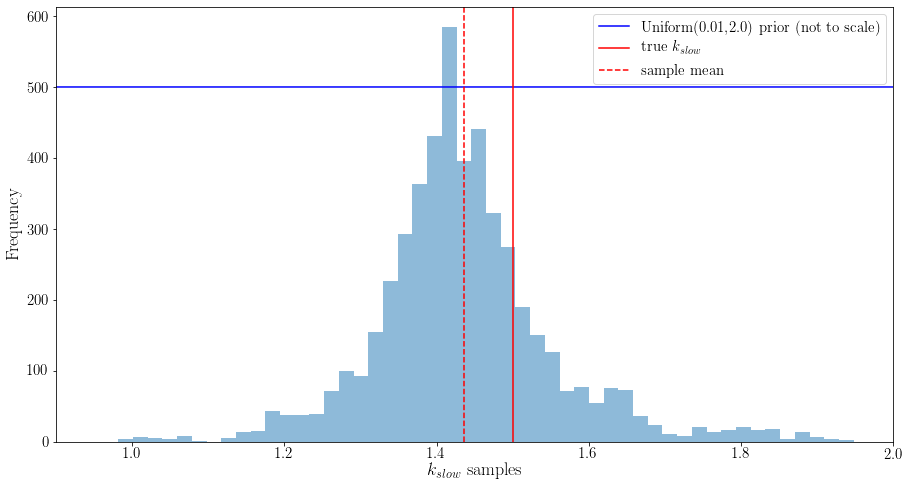

In [59]:
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

x = np.linspace(0, hymod_prior_args.kslow_max*11/10, 200) 
y1 = stats.uniform.pdf(x, loc=0.01, scale=hymod_prior_args.kslow_max)

plt.hist(HYMODtrace_HYMODdata['kslow'],bins=50,alpha=0.5)
plt.plot(x, y1*1000, label=(f'Uniform(0.01,{hymod_prior_args.kslow_max}) prior (not to scale)'),color=colors[0]) 
plt.xlabel(r'$k_{slow}$ samples',fontsize=18)
plt.ylabel(r'Frequency',fontsize=18)
plt.axvline(x=hymod_true_args.kslow,color='r',label=r'true $k_{slow}$')
plt.axvline(x=np.mean(HYMODtrace_HYMODdata['kslow']),color='r',linestyle='--',label='sample mean')
plt.xlim([0.9,2])
plt.legend(prop={'size': 15})

plt.savefig(os.path.join(rd,'data','figures','hymod_kslow_hist.png'))
plt.show()

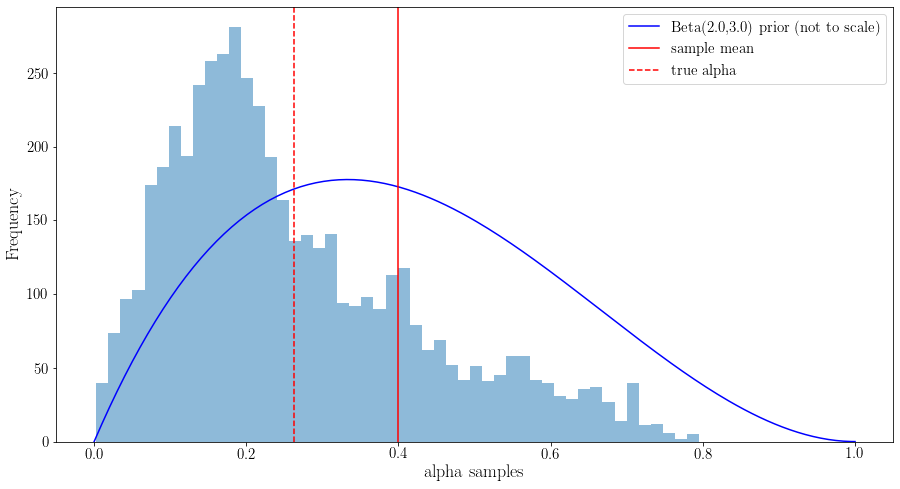

In [34]:
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

x = np.linspace(0, 1, 200) 
y1 = stats.beta.pdf(x, a=hymod_prior_args.alfa_alpha, b=hymod_prior_args.alfa_beta)

plt.hist(HYMODtrace_HYMODdata['alfa'],bins=50,alpha=0.5)
plt.plot(x, y1*100, label=(f'Beta({hymod_prior_args.alfa_alpha},{hymod_prior_args.alfa_beta}) prior (not to scale)'),color=colors[0]) 
plt.xlabel(r'alpha samples',fontsize=18)
plt.ylabel(r'Frequency',fontsize=18)
plt.axvline(x=hymod_true_args.alfa,color='r',label=r'sample mean')
plt.axvline(x=np.mean(HYMODtrace_HYMODdata['alfa']),color='r',linestyle='--',label='true alpha')
plt.legend(prop={'size': 15})

plt.savefig(os.path.join(rd,'data','figures','hymod_alfa_hist.png'))
plt.show()

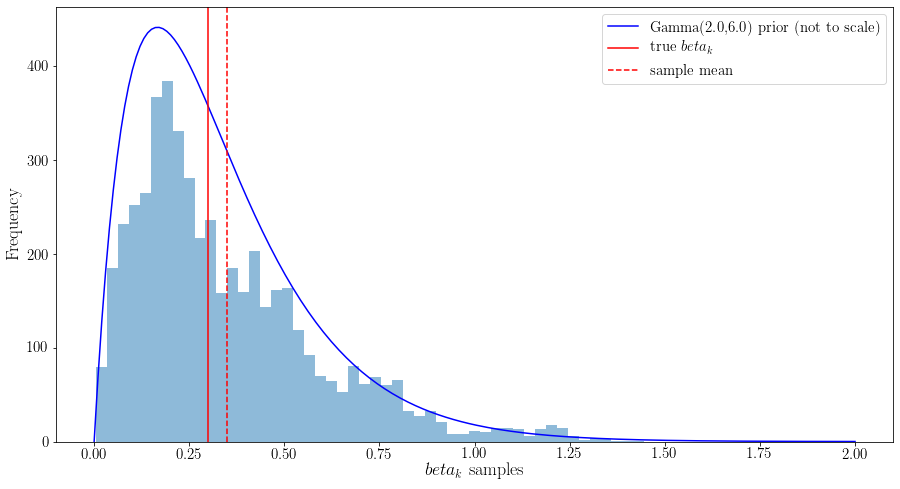

In [40]:
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

x = np.linspace(0, 2, 200) 
y1 = stats.gamma.pdf(x, a=hymod_prior_args.betak_alpha,scale=1/hymod_prior_args.betak_beta)

plt.hist(HYMODtrace_HYMODdata['betak'],bins=50,alpha=0.5)
plt.plot(x, y1*200, label=(f'Gamma({hymod_prior_args.betak_alpha},{hymod_prior_args.betak_beta}) prior (not to scale)'),color=colors[0]) 
plt.xlabel(r'$beta_k$ samples',fontsize=18)
plt.ylabel(r'Frequency',fontsize=18)
plt.axvline(x=hymod_true_args.betak,color='r',label=r'true $beta_k$')
plt.axvline(x=np.mean(HYMODtrace_HYMODdata['betak']),color='r',linestyle='--',label='sample mean')
plt.legend(prop={'size': 15})

plt.savefig(os.path.join(rd,'data','figures','hymod_betak_hist.png'))
plt.show()

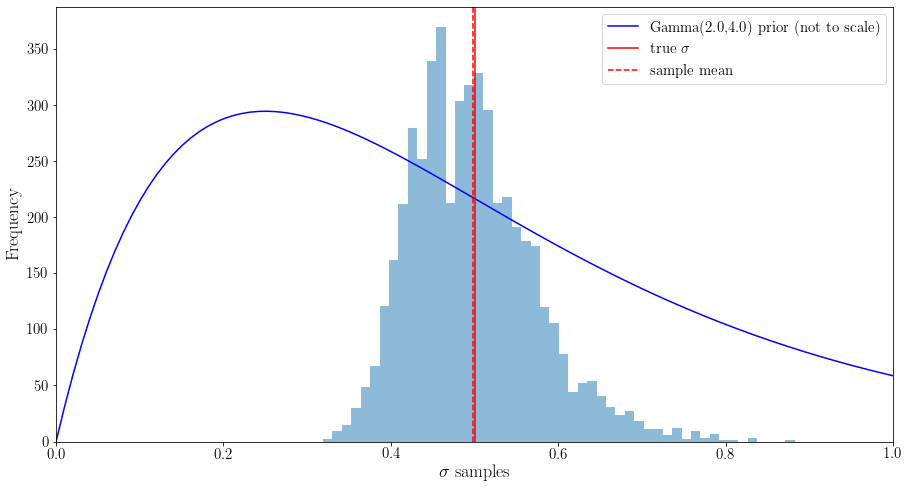

In [61]:
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

x = np.linspace(0, 2, 200) 
y1 = stats.gamma.pdf(x, a=hymod_prior_args.sigma_alpha, scale=1/hymod_prior_args.sigma_beta)

plt.hist(HYMODtrace_HYMODdata['sigma'],bins=50,alpha=0.5)
plt.plot(x, y1*200, label=(f'Gamma({hymod_prior_args.sigma_alpha},{hymod_prior_args.sigma_beta}) prior (not to scale)'),color=colors[0]) 
plt.xlabel(r'$\sigma$ samples',fontsize=18)
plt.ylabel(r'Frequency',fontsize=18)
plt.axvline(x=hymod_true_args.sigma,color='r',label=r'true $\sigma$')
plt.axvline(x=np.mean(HYMODtrace_HYMODdata['sigma']),color='r',linestyle='--',label='sample mean')
plt.xlim([0.,1.])
plt.legend(prop={'size': 15})

plt.savefig(os.path.join(rd,'data','figures','hymod_sigma_hist.png'))
plt.show()

In [ ]:
# with LRMmodel_LRMdata:
#     pm.traceplot(LRMtrace_LRMdata);

In [ ]:
# _ = pm.plot_posterior(LRMtrace_LRMdata,varnames=['k','sigma'])

# Posterior predictive

In [15]:
# Choose number of posterior samples
npostsamples = 1000

In [16]:
hymod_ppc_samples = pm.sample_posterior_predictive(HYMODtrace_HYMODdata, samples=npostsamples, model=HYMODmodel_HYMODdata)['Q_obs']
hymod_mean_ppc = hymod_ppc_samples.mean(axis=0)
hymod_CriL_ppc = np.percentile(hymod_ppc_samples,q=2.5,axis=0)
hymod_CriU_ppc = np.percentile(hymod_ppc_samples,q=97.5,axis=0)

100%|██████████| 1000/1000 [00:03<00:00, 319.25it/s]


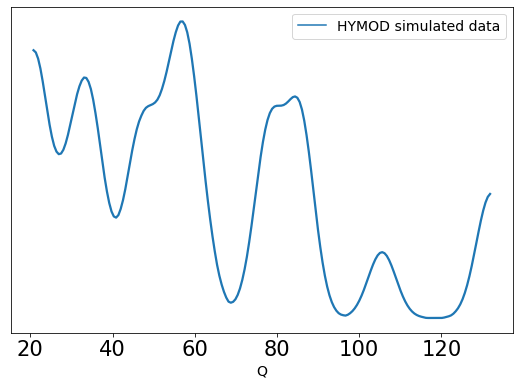

In [13]:
_, ax = plt.subplots(figsize=(9, 6))
pm.kdeplot(np.mean(hymod_ppc_samples.T, 0), ax=ax, plot_kwargs={'color':'C0'})
ax.plot([], label='HYMOD simulated data')
ax.legend(fontsize=14)
ax.set_xlabel(u'Q', fontsize=14)
ax.set_yticks([]);

In [21]:
t1,t2 = 0,25
factor = 1.1

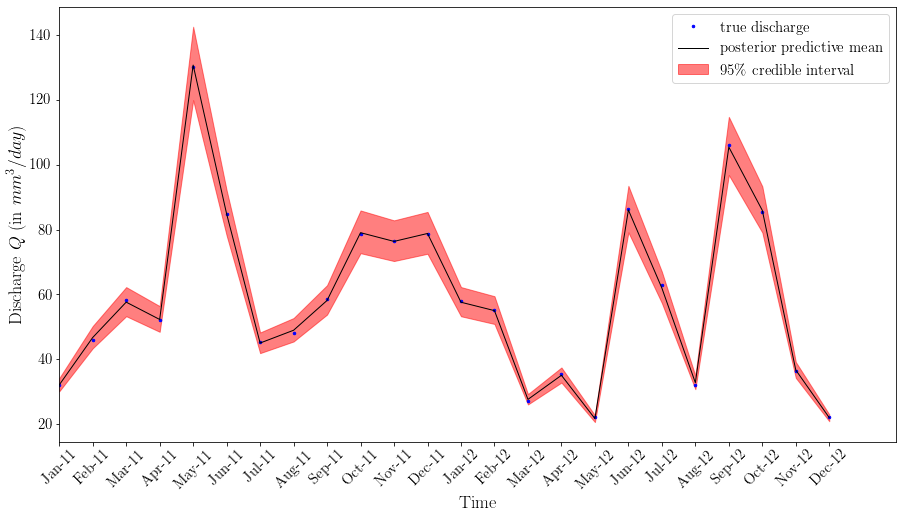

In [22]:
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=15)

plt.plot(model2data['time'][t1:t2],model2data['discharge'][t1:t2],'o', color='b', lw=1, ms=2.5,label=r'true discharge')
plt.plot(model2data['time'][t1:t2],hymod_mean_ppc[t1:t2,0], color='k', lw=1,label=r'posterior predictive mean')
# plt.plot(model2data['time'][t1:t2],hymod_CriL_ppc[t1:t2,0], '--', color='b', lw=0.5)
# plt.plot(model2data['time'][t1:t2],hymod_CriU_ppc[t1:t2,0], '--',  color='b', lw=0.5)
plt.fill_between(model2data['time'][t1:t2], factor*hymod_CriL_ppc[t1:t2,0], (1/factor)*hymod_CriU_ppc[t1:t2,0],color='r',alpha=0.5,label=r'95\% credible interval')
plt.xlim([t1,t2])
plt.ylabel(r'Discharge $Q$ (in $mm^3/day$)', fontsize=18)
plt.xlabel(r'Time',fontsize=18)
plt.xticks(ticks=model2data['time'][t1:t2],labels=model2data['time_label'][t1:t2],rotation=45)
plt.legend()

# plt.savefig(os.path.join(rd,'data','figures/hymod_predictions.png'))
plt.show()